# Metabolic Syndrome Prediction
- David Atkins

## Part 1

### Imports / Functions

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

### EDA

#### **Data Dictionary**
![Data Dictionary](data\data_dict.jpg)

In [6]:
# load data
df = pd.read_csv('data\Metabolic  Syndrome.csv')
# preview data
df.head()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [7]:
df['Income']=df['Income'].astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             Int64  
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: Int64(1), float64(4), int64(6), object(4)
memory usage: 283.8+ KB


In [8]:
df['seqn'].nunique()

2401

In [9]:
df = df.set_index('seqn')
df.head(3)

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn


In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

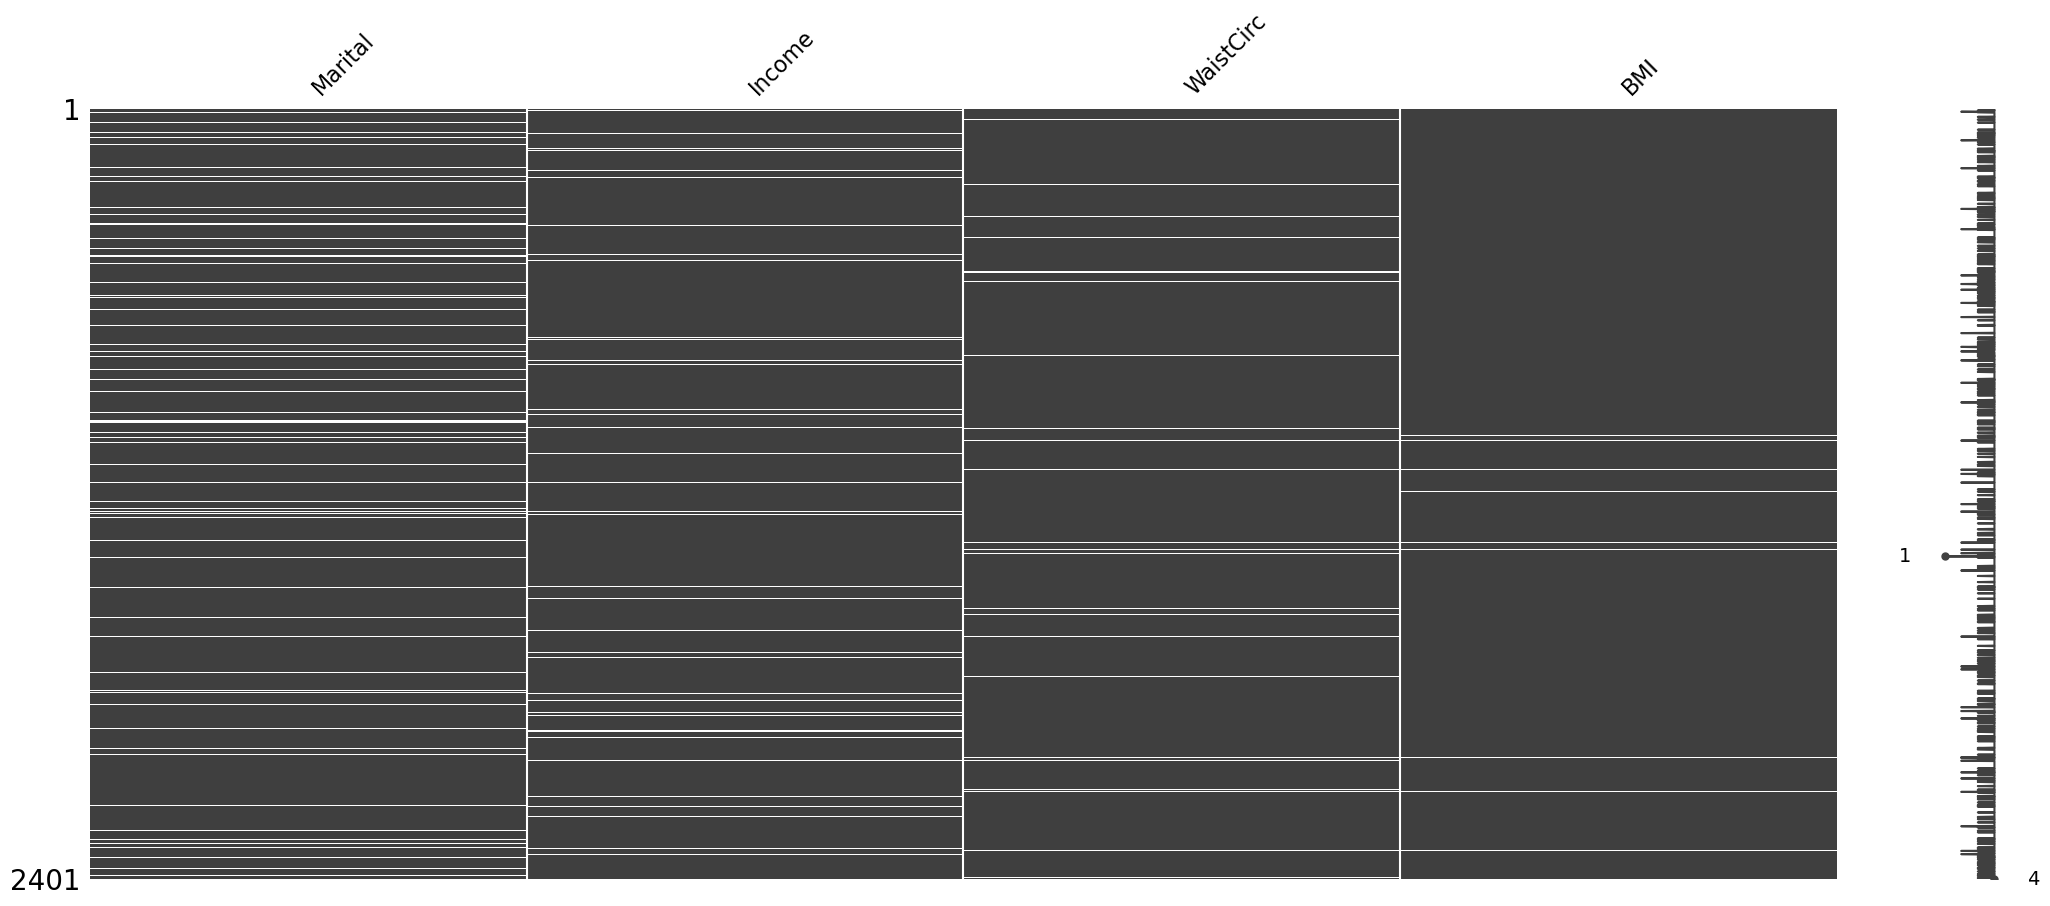

In [12]:
missingno.matrix(df[['Marital','Income','WaistCirc','BMI']]);

In [13]:
df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [15]:
df['Marital'].isna().sum()

208

In [16]:
df.describe(include='object')

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


In [17]:
df['Sex'].value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [18]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [19]:
# Sex and MetabolicSyndrome binary encoding
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].map({'MetSyn': 1, 'No MetSyn': 0})
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,1,Single,8200,White,81.0,23.3,0,3.88,4.9,92,41,84,0
62164,44,0,Married,4500,White,80.1,23.2,0,8.55,4.5,82,28,56,0
62169,21,1,Single,800,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
62172,43,0,Single,2000,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
62177,51,1,Married,<NA>,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [20]:
df.describe(exclude='object')

,Age,Sex,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2401.000000,2284.0,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,0.495627,4005.25394,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,0.500085,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,0.000000,300.0,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,0.000000,1600.0,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,0.000000,2500.0,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,1.000000,6200.0,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,1.000000,9000.0,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


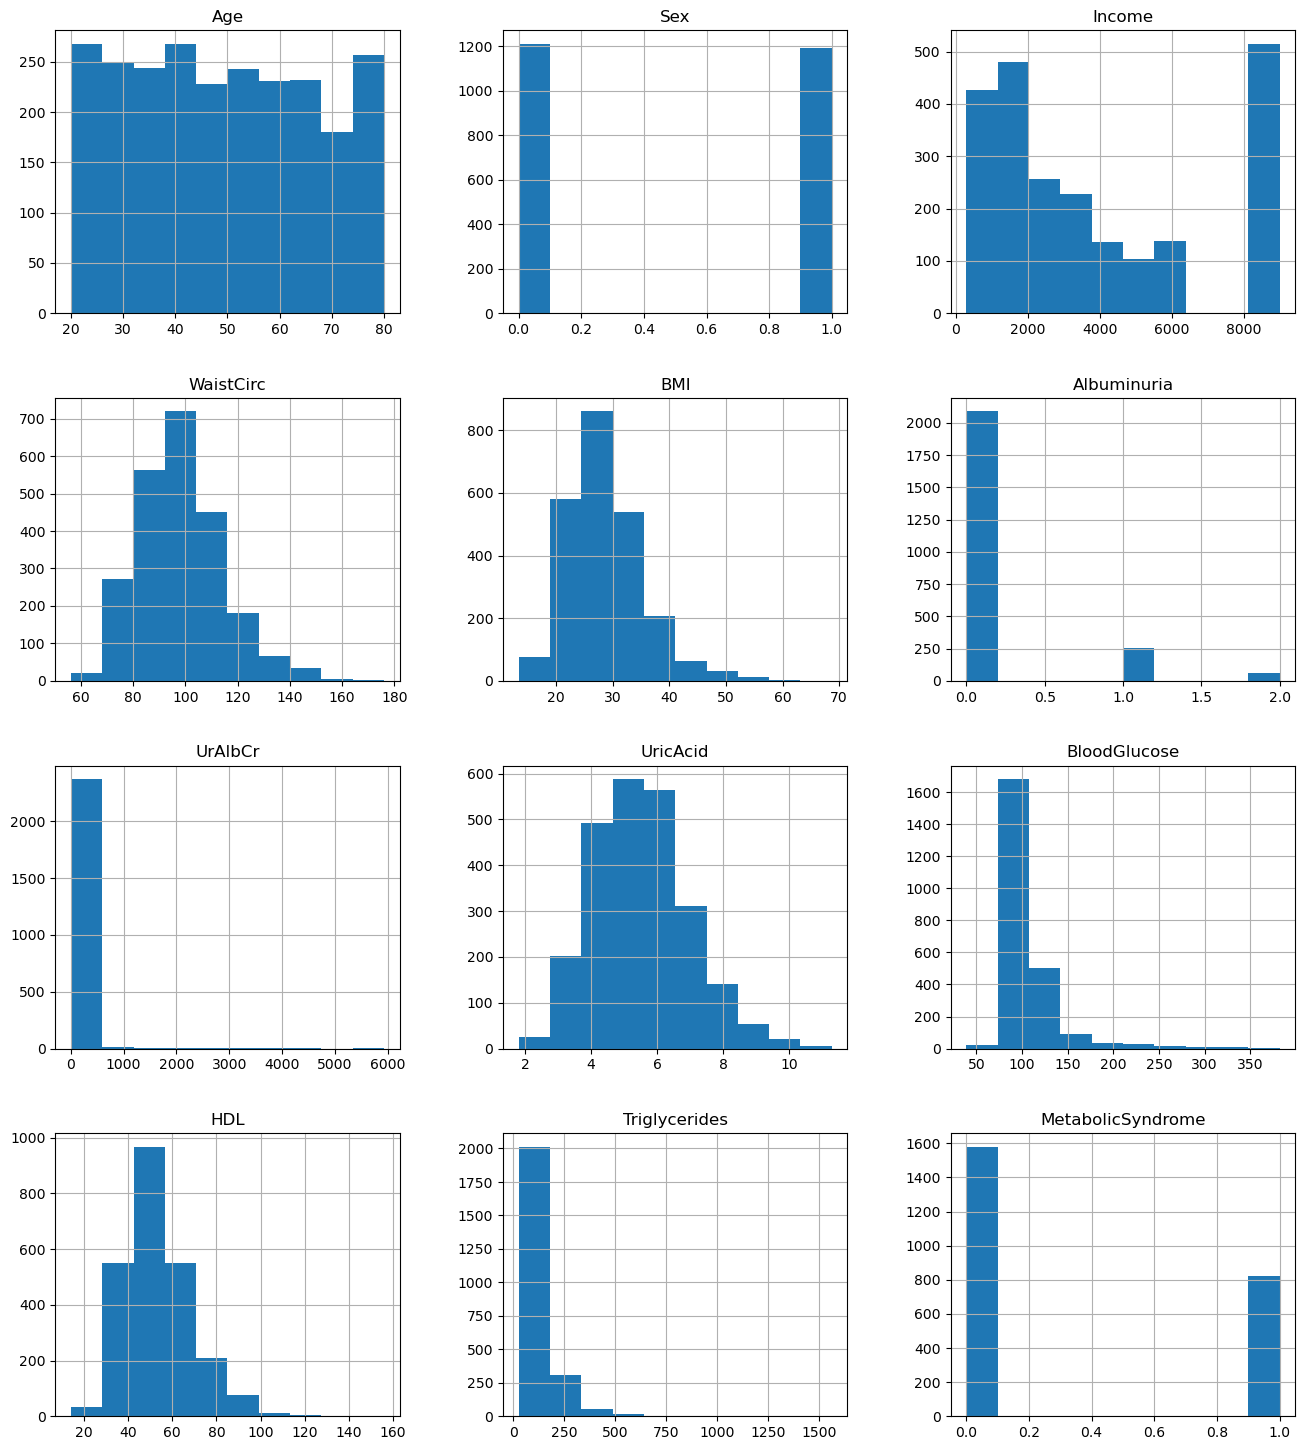

In [21]:
df.hist(figsize=(16,18));

Marital count plot 



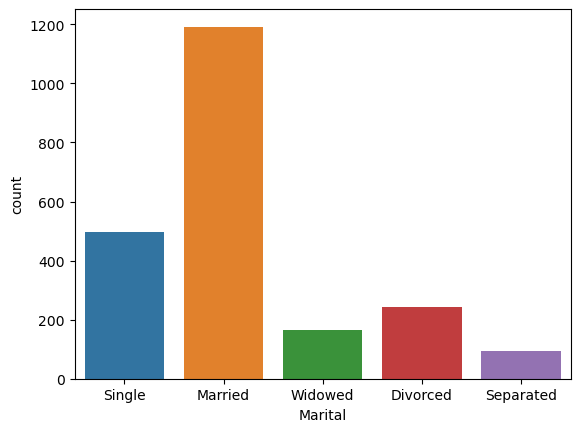

Race count plot 



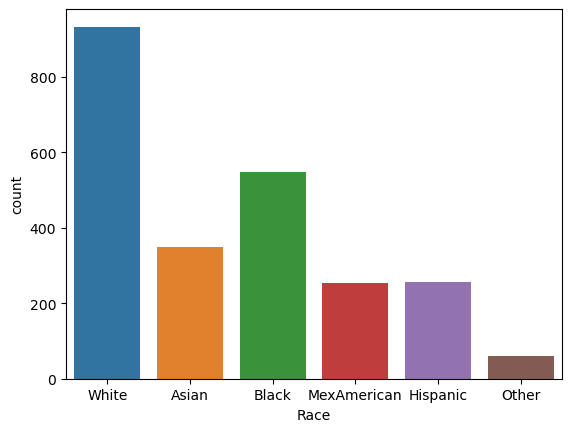

In [22]:
for col in df.select_dtypes('object').columns:
    print(col +' count plot \n') 
    sns.countplot(x =col, data =df)
    plt.show()

### Model

In [23]:
cat_cols = ['Sex', 'Marital','Race']
num_cols = ['Age','Income','WaistCirc','BMI','Albuminuria','UrAlbCr','UricAcid','BloodGlucose','HDL','Triglycerides']

In [24]:
#x train split
# Separating X,y and train test split
target = 'MetabolicSyndrome'
X = df.drop(columns=target).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

#### Preprocessor

In [25]:
# Categorical Pipeline / Tuple
# Using value 'Undisclosed' to fill in null values (all in 'Marital')
impute_missing = SimpleImputer(strategy='constant',fill_value='Undisclosed')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

nom_pipe = make_pipeline(impute_missing, ohe_encoder, scaler)
nom_pipe

# Nominal Tuple
nom_tuple = ('categorical', nom_pipe, cat_cols)

nom_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Undisclosed', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                 ('standardscaler', StandardScaler())]),
 ['Sex', 'Marital', 'Race'])

In [26]:
# Numeric Pipeline / Tuple
# Using median imputation strategy
mean_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
num_pipe = make_pipeline(mean_imputer, scaler)
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 ['Age',
  'Income',
  'WaistCirc',
  'BMI',
  'Albuminuria',
  'UrAlbCr',
  'UricAcid',
  'BloodGlucose',
  'HDL',
  'Triglycerides'])

In [27]:
preprocessor = ColumnTransformer([num_tuple, nom_tuple],
                                    verbose_feature_names_out=False, remainder='drop')

In [28]:
# Define KNN model pipeline
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Instantiate default KNN
knn = KNeighborsClassifier()
knn.fit(X_train_proc, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1182
           1       0.85      0.69      0.76       618

    accuracy                           0.85      1800
   macro avg       0.85      0.81      0.83      1800
weighted avg       0.85      0.85      0.85      1800



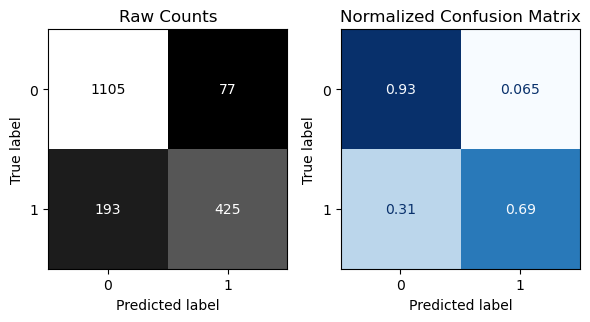


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       397
           1       0.69      0.56      0.62       204

    accuracy                           0.77       601
   macro avg       0.74      0.72      0.72       601
weighted avg       0.76      0.77      0.76       601



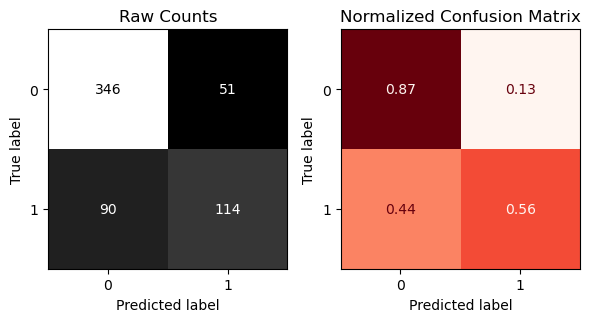

In [29]:
# evaluate
evaluate_classification(knn, X_train_proc, y_train, X_test_proc, y_test)

#### Calculating Feature Importance

In [30]:
## Calculate feature importances
importances = permutation_importance(knn, X_test_proc, y_test)

## Create a Series of Feature Importances
importances = pd.Series(importances['importances_mean'], index=knn.feature_names_in_)
importances = importances.sort_values(ascending=False)
importances.head(10)

Triglycerides       0.039268
BMI                 0.019634
BloodGlucose        0.018968
WaistCirc           0.015308
HDL                 0.012978
Age                 0.007987
Race_MexAmerican    0.007321
Race_Asian          0.001997
Race_Hispanic       0.001664
UricAcid            0.001331
dtype: float64

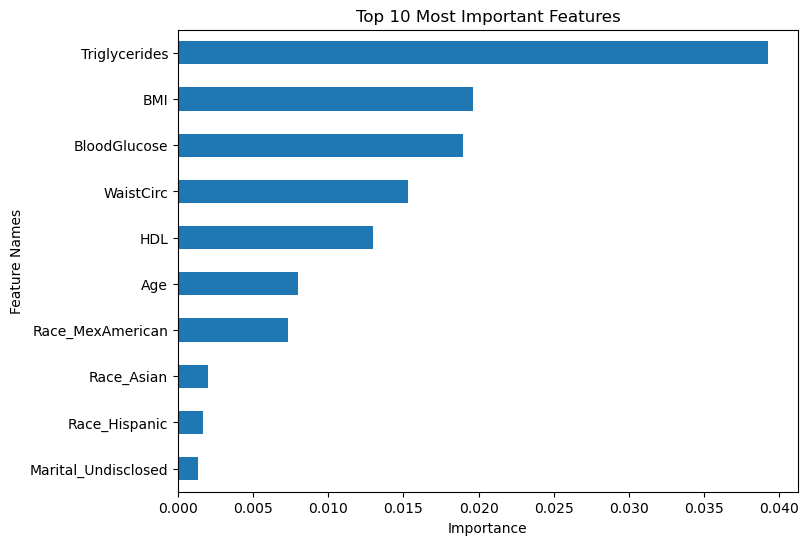

In [31]:
plot_importance(importances,top_n=10);

#### Obervations: 
- As expected the physical factors such as BMI/WaistCirc and Triglycerides are important
- Genetic Heritage (Race) also seems important, also making sense
- The importance of the undisclosed marital status seems a little odd, if I were not pursuing a minimum viable product I may dig into that

### Model Visualizations

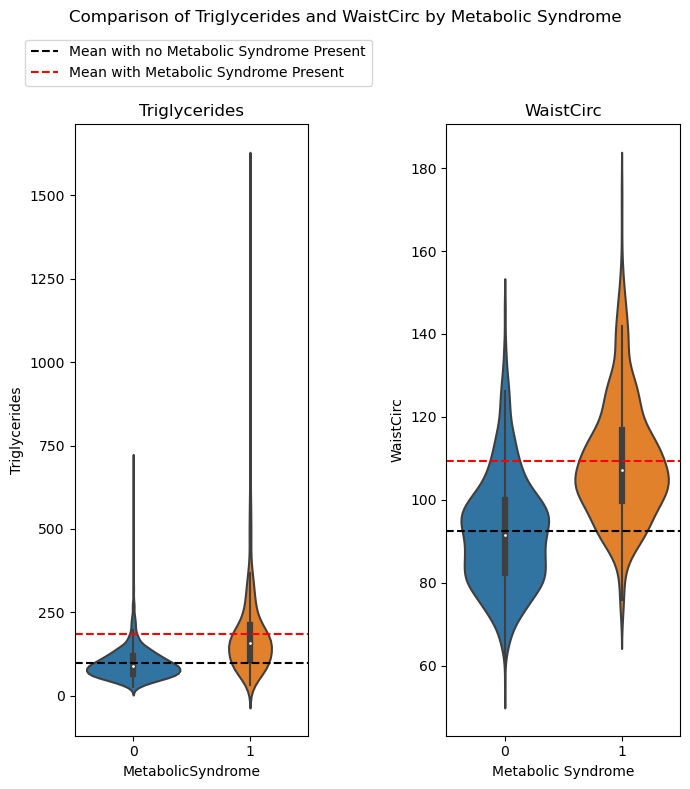

In [32]:
means_trig = df.groupby('MetabolicSyndrome')['Triglycerides'].mean()
means_waist = df.groupby('MetabolicSyndrome')['WaistCirc'].mean()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 8))

# Plot Triglycerides violin plot
sns.violinplot(x="MetabolicSyndrome", y="Triglycerides", data=df, ax=axes[0])
axes[0].axhline(y=means_trig[0], color='black', linestyle='--', 
                label='Mean with no Metabolic Syndrome Present')
axes[0].axhline(y=means_trig[1], color='red', linestyle='--', 
                label='Mean with Metabolic Syndrome Present')
axes[0].legend(bbox_to_anchor=(1.3, 1.15))
axes[0].set_title("Triglycerides")

# Plot WaistCirc violin plot
sns.violinplot(x="MetabolicSyndrome", y="WaistCirc", data=df, ax=axes[1])
axes[1].axhline(y=means_waist[0], color='black', linestyle='--')
axes[1].axhline(y=means_waist[1], color='red', linestyle='--')
axes[1].set_title("WaistCirc")

# Adjust labels and title
plt.xlabel("Metabolic Syndrome")
plt.suptitle("Comparison of Triglycerides and WaistCirc by Metabolic Syndrome")

# Tighten layout
plt.tight_layout()

- In both of these cases the mean is higher for those with Metabolic Syndrome.
- Higher Tryglycerides and Waist Circumference indicate higher risk of Metabolic Syndrome

## Part 2

#### PCA Transform / Model

In [35]:
pca = PCA(n_components=.85)

In [36]:
pca_pre = make_pipeline(preprocessor, pca)

In [37]:
X_train_pca = pca_pre.fit_transform(X_train)
X_test_pca = pca_pre.transform(X_test)

In [38]:
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1182
           1       0.84      0.75      0.79       618

    accuracy                           0.87      1800
   macro avg       0.86      0.84      0.85      1800
weighted avg       0.87      0.87      0.86      1800



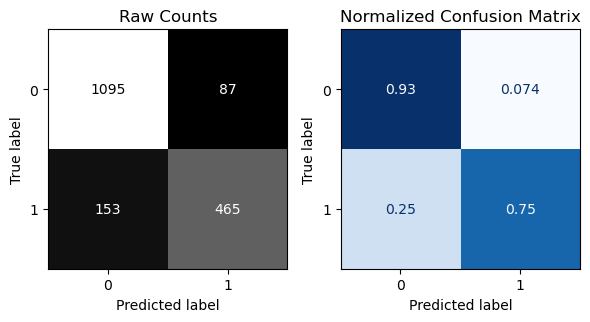


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       397
           1       0.73      0.62      0.67       204

    accuracy                           0.79       601
   macro avg       0.77      0.75      0.76       601
weighted avg       0.79      0.79      0.79       601



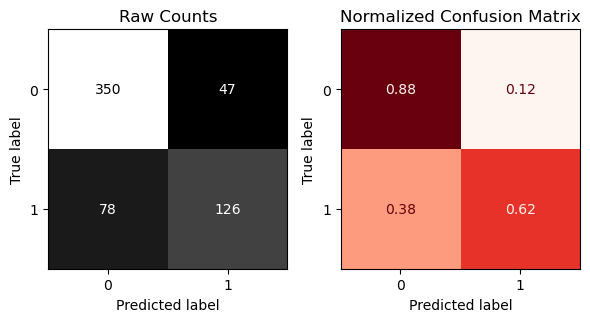

In [39]:
evaluate_classification(knn_pca, X_train_pca, y_train, 
                 X_test_pca, y_test)

- This model performs ~2%-3% better than the first model in accuracy, precision, recall, and f1 score. 

#### Forward Selection Wrapper

In [75]:
X_train_wrap = preprocessor.fit_transform(X_train)
X_test_wrap = preprocessor.transform(X_test)

In [61]:
y.value_counts()

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

In [62]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_wrap, y_train)
y_train_sm.value_counts()

1    1182
0    1182
Name: MetabolicSyndrome, dtype: int64

In [70]:
sk_sfs = SequentialFeatureSelector(knn_wrap, n_features_to_select=10,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_sm,y_train_sm)

SequentialFeatureSelector(cv=2, estimator=KNeighborsClassifier(),
                          n_features_to_select=10, n_jobs=-1)

In [71]:
sk_sfs.support_[0:5]

array([False, False,  True,  True, False])

In [72]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_10 = X_train_sel.loc[:,features_to_keep]
X_test_10 = X_test_sel.loc[:,features_to_keep]
X_train_10.shape

(2364, 10)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1182
           1       0.90      0.93      0.91      1182

    accuracy                           0.91      2364
   macro avg       0.91      0.91      0.91      2364
weighted avg       0.91      0.91      0.91      2364



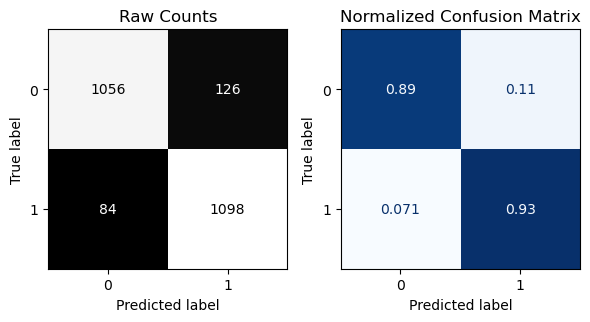


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       397
           1       0.70      0.82      0.76       204

    accuracy                           0.82       601
   macro avg       0.80      0.82      0.81       601
weighted avg       0.83      0.82      0.82       601



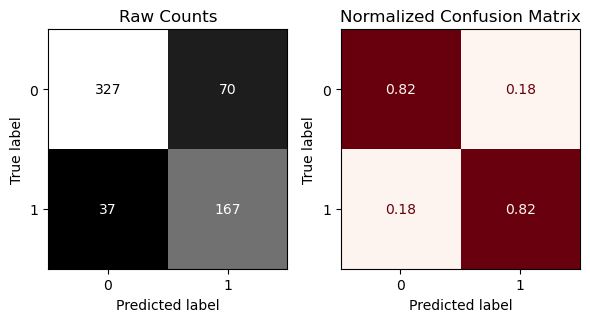

In [73]:
knn_wrap = KNeighborsClassifier()
knn_wrap.fit(X_train_10, y_train_sm)
evaluate_classification(knn_wrap, X_train_10, y_train_sm, X_test_10, y_test)

- This model performs better than the first model 2 models. 
- accuracy: .83
- precision: .83
- recall: .82
- f1 score: .82

In [81]:
## Calculate feature importances
importances = permutation_importance(knn_wrap, X_test_10, y_test)

## Create a Series of Feature Importances
importances = pd.Series(importances['importances_mean'], index=knn_wrap.feature_names_in_)
importances = importances.sort_values(ascending=False)
importances.head(10)

Sex_0               0.082529
Sex_1               0.082529
BloodGlucose        0.062230
Triglycerides       0.057571
WaistCirc           0.045258
HDL                 0.037604
UrAlbCr             0.008985
BMI                 0.007321
Race_Hispanic       0.000333
Marital_Divorced   -0.001331
dtype: float64

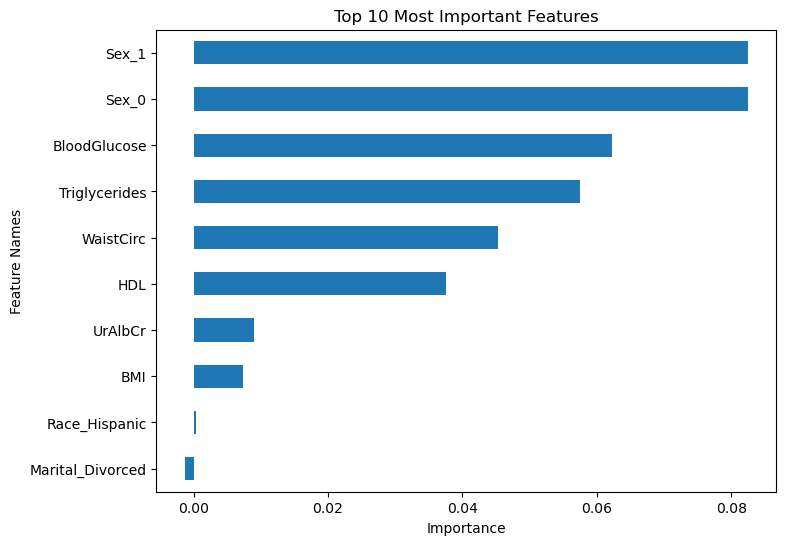

In [82]:
plot_importance(importances,top_n=10);

- The core features in both models are the same, the phyiscal indicators.
- These include Triglycerides, BMI, Blood Glucose, Waist Circumference, and HDL
- This updated model has Sex introduced to the top 10 features as the most important